<a href="https://colab.research.google.com/github/Zermeene/Movie-Recommendation-System/blob/main/Copy_of_2023786.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zermine wajid
2023786

COde for extraction

In [ ]:
import zipfile
import os

# Define path to the ZIP file
zip_path = "/content/archive (3).zip"
extract_path = "/mnt/data/facades_dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the extracted files
print("Extracted files:", os.listdir(extract_path))


Extracted files: ['testA', 'metadata.csv', 'trainA', 'testB', 'trainB']


Viewing dataset file


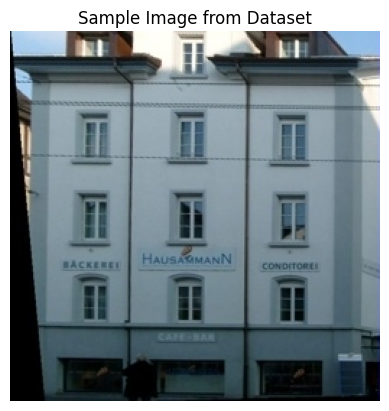

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the path
dataset_path = "/mnt/data/facades_dataset"

# Get the list of files in one of the dataset folders (e.g., 'trainA')
image_folder = os.path.join(dataset_path, "trainA")
image_files = os.listdir(image_folder)

# Select a sample image
sample_image_path = os.path.join(image_folder, image_files[0])

# Open the image using PIL
image = Image.open(sample_image_path)

# Display the image
plt.imshow(image)
plt.axis("off")
plt.title("Sample Image from Dataset")
plt.show()


Checking if extraction was successful
seeinf thepath

In [ ]:
import os

# Define dataset path
dataset_path = "/mnt/data/facades_dataset"
image_folder = os.path.join(dataset_path, "trainA")  # Change this based on the dataset

# Check if the folder exists
if not os.path.exists(image_folder):
    print("❌ The folder does not exist. Check if the extraction was successful.")
else:
    # List available files
    image_files = os.listdir(image_folder)

    if len(image_files) == 0:
        print("❌ No images found in the dataset folder.")
    else:
        print("✅ Available images:", image_files[:5])  # Show first 5 images

        # Select a valid image file
        sample_image_path = os.path.join(image_folder, image_files[0])
        print("Using sample image:", sample_image_path)


✅ Available images: ['187_A.jpg', '22_A.jpg', '294_A.jpg', '166_A.jpg', '224_A.jpg']
Using sample image: /mnt/data/facades_dataset/trainA/187_A.jpg


Creating python generator to load images ...splitting image

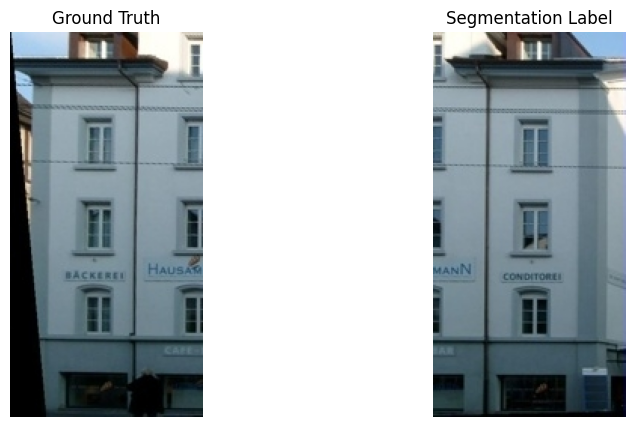

In [ ]:
import numpy as np

def split_image(image_path):
    """
    Reads an image, splits it into ground truth (left) and segmentation label (right).
    """
    image = Image.open(image_path)  # Load image
    width, height = image.size  # Get dimensions

    # Split into two equal halves
    mid = width // 2
    ground_truth = image.crop((0, 0, mid, height))  # Left half
    segmentation_label = image.crop((mid, 0, width, height))  # Right half

    return ground_truth, segmentation_label

# Test function
ground_truth, segmentation_label = split_image(sample_image_path)

# Show both images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(ground_truth)
axes[0].set_title("Ground Truth")
axes[0].axis("off")

axes[1].imshow(segmentation_label)
axes[1].set_title("Segmentation Label")
axes[1].axis("off")

plt.show()


Noe generator to load images in batches

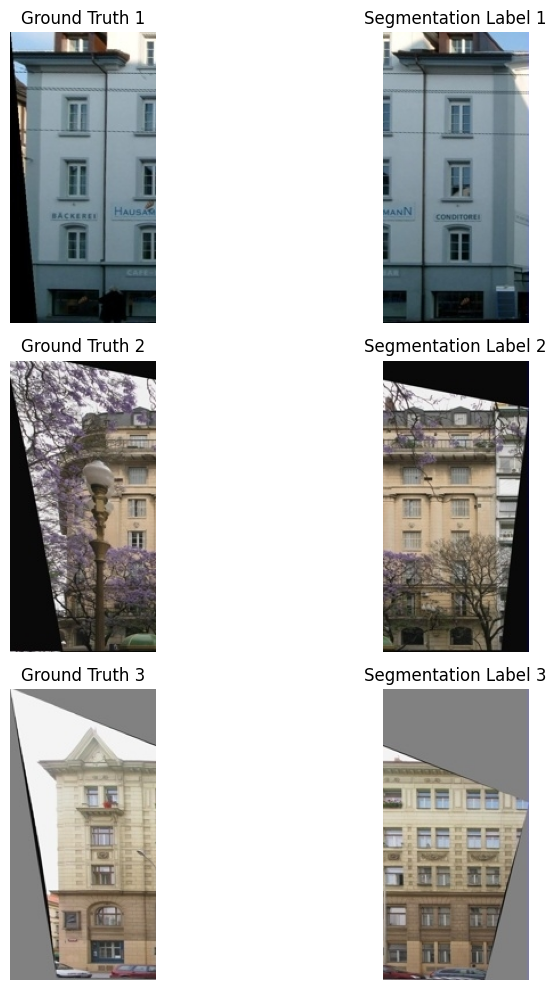

In [ ]:
def image_generator(folder_path, batch_size=1):
    """
    A generator function to load and split images from the dataset.
    Yields batches of (ground_truth, segmentation_label) images.
    """
    image_files = os.listdir(folder_path)  # List all images

    for i in range(0, len(image_files), batch_size):
        batch_ground_truth = []
        batch_segmentation_label = []

        for j in range(batch_size):
            if i + j < len(image_files):  # Ensure we don't go out of range
                image_path = os.path.join(folder_path, image_files[i + j])
                image_path = os.path.normpath(image_path)  # Fix path format

                # Load and split image
                ground_truth, segmentation_label = split_image(image_path)

                # Convert images to NumPy arrays
                batch_ground_truth.append(np.array(ground_truth))
                batch_segmentation_label.append(np.array(segmentation_label))

        yield np.array(batch_ground_truth), np.array(batch_segmentation_label)

# Test generator with 3 images
gen = image_generator(image_folder, batch_size=3)

# Get one batch
ground_truth_batch, segmentation_label_batch = next(gen)

# Display 3 images side by side
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
    axes[i, 0].imshow(ground_truth_batch[i])
    axes[i, 0].set_title(f"Ground Truth {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(segmentation_label_batch[i])
    axes[i, 1].set_title(f"Segmentation Label {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()









display the 5 sample

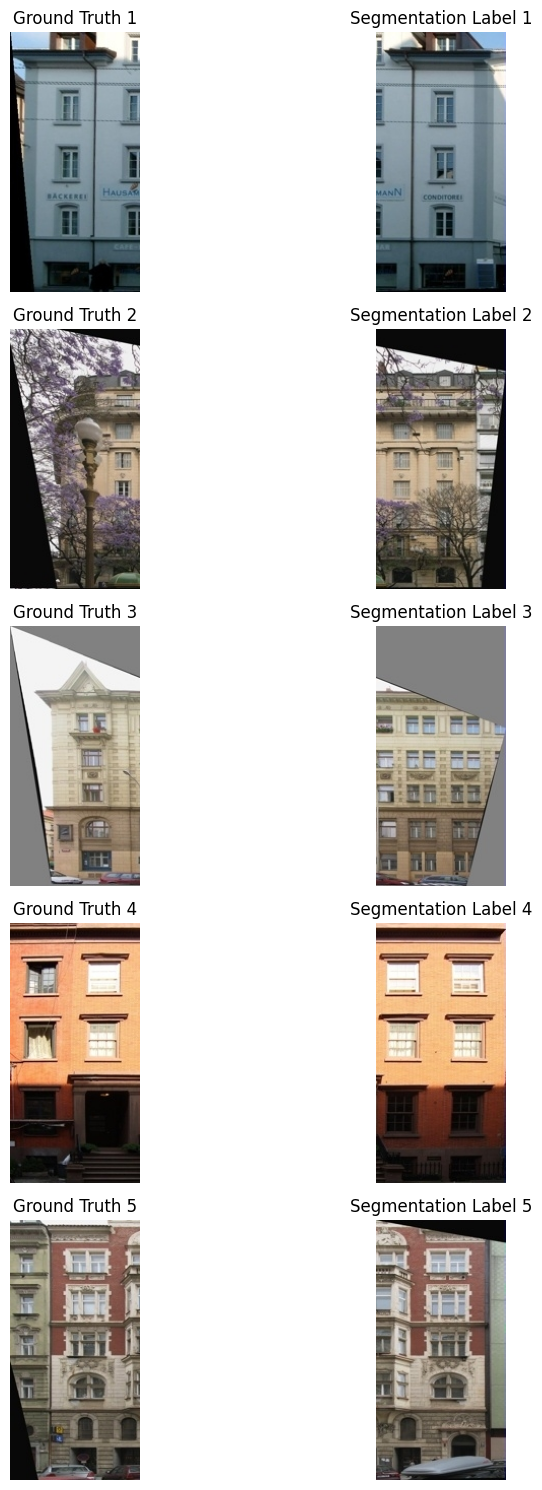

In [ ]:
# Get 5 samples from the generator
gen = image_generator(image_folder, batch_size=5)
ground_truth_batch, segmentation_label_batch = next(gen)

# Display the 5 images side by side
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i in range(5):
    # Display Ground Truth
    axes[i, 0].imshow(ground_truth_batch[i])
    axes[i, 0].set_title(f"Ground Truth {i+1}")
    axes[i, 0].axis("off")

    # Display Segmentation Label
    axes[i, 1].imshow(segmentation_label_batch[i])
    axes[i, 1].set_title(f"Segmentation Label {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()



```
TRAINING TIME!!! :(

```



Installed lib required

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os


preprocessed dataset

In [ ]:
def preprocess_image(image, target_size=(128, 128)):
    """
    Resizes an image and normalizes pixel values.
    """
    image = image.resize(target_size)  # Resize
    image = np.array(image) / 255.0  # Normalize (0 to 1 range)
    return image

# Modify generator to preprocess images
def image_generator(folder_path, batch_size=16, target_size=(128, 128)):
    """
    A generator function to load, split, and preprocess images.
    """
    image_files = os.listdir(folder_path)
    np.random.shuffle(image_files)

    for i in range(0, len(image_files), batch_size):
        batch_ground_truth = []
        batch_segmentation_label = []

        for j in range(batch_size):
            if i + j < len(image_files):
                image_path = os.path.join(folder_path, image_files[i + j])
                ground_truth, segmentation_label = split_image(image_path)

                # Preprocess images
                batch_ground_truth.append(preprocess_image(ground_truth, target_size))
                batch_segmentation_label.append(preprocess_image(segmentation_label, target_size))

        yield np.array(batch_ground_truth), np.array(batch_segmentation_label)

# Check generator output
gen = image_generator(image_folder, batch_size=3)
X_batch, Y_batch = next(gen)
print(f"✅ Batch shape: {X_batch.shape}, {Y_batch.shape}")


✅ Batch shape: (3, 128, 128, 3), (3, 128, 128, 3)


define CNN model

In [ ]:
def build_model(input_shape=(128, 128, 3)):
    model = Sequential()

    # Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

# Build and summarize model
model = build_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

# **TRAINING IT!!! :))**

In [ ]:
# Create data generator
train_gen = image_generator(image_folder, batch_size=16)

# Train model
model.fit(train_gen, epochs=10, steps_per_epoch=100)

# Save model
model.save("/mnt/data/segmentation_model.h5")
print("✅ Model saved successfully!")


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.0560
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0518    
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0509    
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0503    
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0496    
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0492
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0484
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0481    
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0477    
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0470    


✅ Model saved successfully!


REDOING CUZ ITS NOT WORKING

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# New Image Size
TARGET_SIZE = (256, 256)

# Preprocessing Function (Updated for 256x256 images)
def preprocess_image(image, target_size=TARGET_SIZE):
    """
    Resizes an image and normalizes pixel values.
    """
    image = image.resize(target_size)  # Resize
    image = np.array(image) / 255.0  # Normalize (0 to 1 range)
    return image

# Data Generator with Augmentation (NEW)
def image_generator(folder_path, batch_size=16):
    """
    A generator function to load, split, preprocess, and augment images.
    """
    image_files = os.listdir(folder_path)
    np.random.shuffle(image_files)

    datagen = ImageDataGenerator(
        rotation_range=20,  # Random rotation
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True  # Flip horizontally
    )

    for i in range(0, len(image_files), batch_size):
        batch_ground_truth = []
        batch_segmentation_label = []

        for j in range(batch_size):
            if i + j < len(image_files):
                image_path = os.path.join(folder_path, image_files[i + j])
                ground_truth, segmentation_label = split_image(image_path)

                # Preprocess images
                ground_truth = preprocess_image(ground_truth, TARGET_SIZE)
                segmentation_label = preprocess_image(segmentation_label, TARGET_SIZE)

                batch_ground_truth.append(ground_truth)
                batch_segmentation_label.append(segmentation_label)

        # Apply augmentation
        batch_ground_truth = np.array(batch_ground_truth)
        batch_segmentation_label = np.array(batch_segmentation_label)

        yield next(datagen.flow(batch_ground_truth, batch_size=batch_size, shuffle=False)), \
              next(datagen.flow(batch_segmentation_label, batch_size=batch_size, shuffle=False))

# Improved Model with Dropout
def build_improved_model(input_shape=(256, 256, 3)):
    model = Sequential()

    # Encoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.2))  # Dropout added

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.2))  # Dropout added

    # Decoder
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output layer

    # Changed Loss Function to Binary Cross-Entropy
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

    return model

# Build Model
model = build_improved_model()
model.summary()

# Training with More Epochs
train_gen = image_generator(image_folder, batch_size=16)
model.fit(train_gen, epochs=20, steps_per_epoch=100)  # Increased epochs from 10 to 20

# Save Model
model.save("/mnt/data/segmentation_model_v2.keras")  # Recommended format
print("✅ Improved Model Saved Successfully!")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,755 (1.14 MB)

 Trainable params: 298,755 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - loss: 0.6871  
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 127ms/step - loss: 0.6770
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - loss: 0.6772
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - loss: 0.6745
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - loss: 0.6751
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 114ms/step - loss: 0.6736
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - loss: 0.6737
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - loss: 0.6732
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 0.6723
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - loss: 0.6726
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - loss: 0.6718
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - loss: 0.6716
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 0.6715
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - loss: 0.6711
Epoch 15/20
100

Evaluation


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


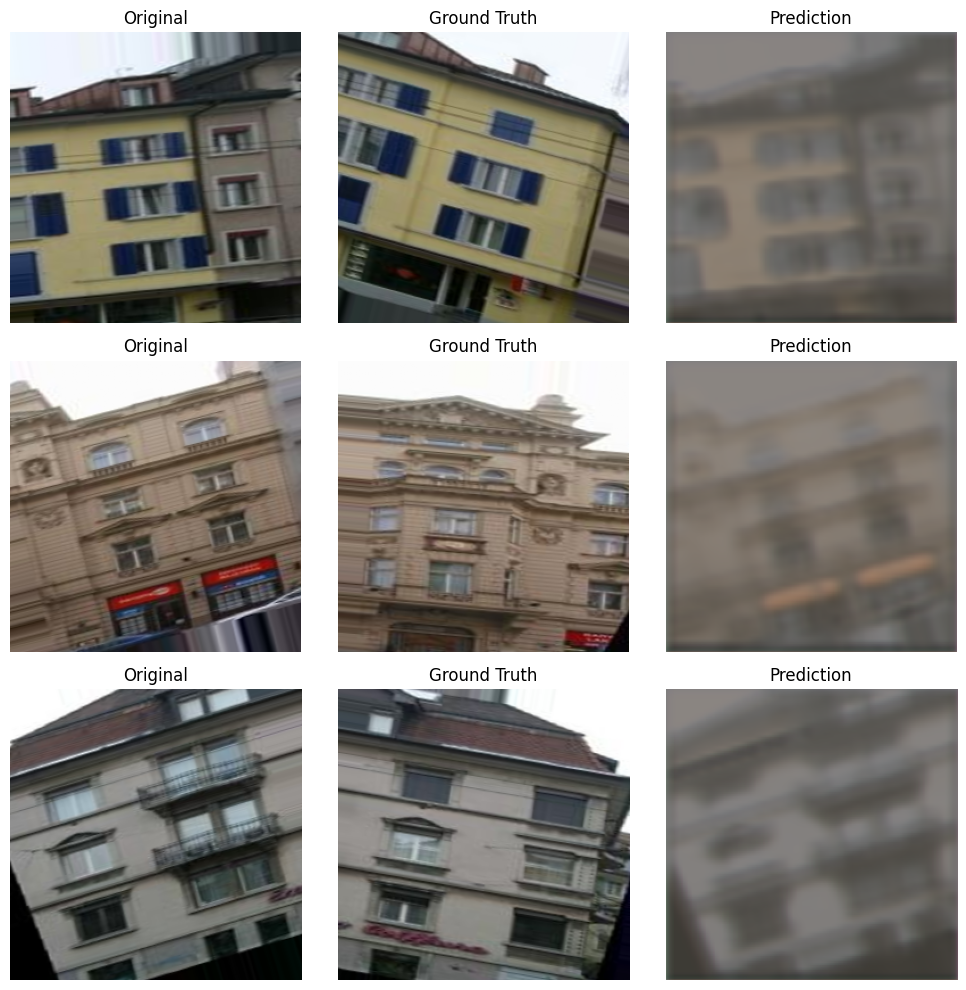

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the trained model
model_path = "/mnt/data/segmentation_model_v2.keras"  # Updated to recommended format
model = tf.keras.models.load_model(model_path)

# Get test images
test_folder = os.path.join(dataset_path, "testA")
test_gen = image_generator(test_folder, batch_size=3)  # Using updated generator
X_test, Y_test = next(test_gen)

# Predict segmentations
predictions = model.predict(X_test)

# Display results
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(Y_test[i])
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(predictions[i])
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


model performance evaluation and metrics

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to compute PSNR & SSIM
def evaluate_model(predictions, ground_truth):
    psnr_values = []
    ssim_values = []

    for i in range(len(predictions)):
        pred = predictions[i]
        gt = ground_truth[i]

        # Compute PSNR
        psnr_value = psnr(gt, pred, data_range=1.0)  # Normalized images (0 to 1)

        # Compute SSIM with fixed win_size & channel_axis
        ssim_value = ssim(gt, pred, data_range=1.0, win_size=3, channel_axis=-1)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    # Compute Mean PSNR & SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Evaluate Model
avg_psnr, avg_ssim = evaluate_model(predictions, Y_test)

print(f"📊 Model Evaluation Metrics:")
print(f"✅ Average PSNR: {avg_psnr:.3f}")
print(f"✅ Average SSIM: {avg_ssim:.3f}")


📊 Model Evaluation Metrics:
✅ Average PSNR: 12.712
✅ Average SSIM: 0.529


improve model

In [ ]:
import tensorflow.keras.backend as K

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Custom loss: Combine SSIM & MSE
def combined_loss(y_true, y_pred):
    return 0.5 * K.mean(K.square(y_true - y_pred)) + 0.5 * ssim_loss(y_true, y_pred)

# Compile Model with Combined Loss
model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss)


In [ ]:
import os
print(os.listdir("/mnt/data/"))



['facades_dataset', 'segmentation_model_v2.keras', 'segmentation_model.h5']


updated evaluation code

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
📊 Model Evaluation Metrics:
✅ Average PSNR: 13.347
✅ Average SSIM: 0.317


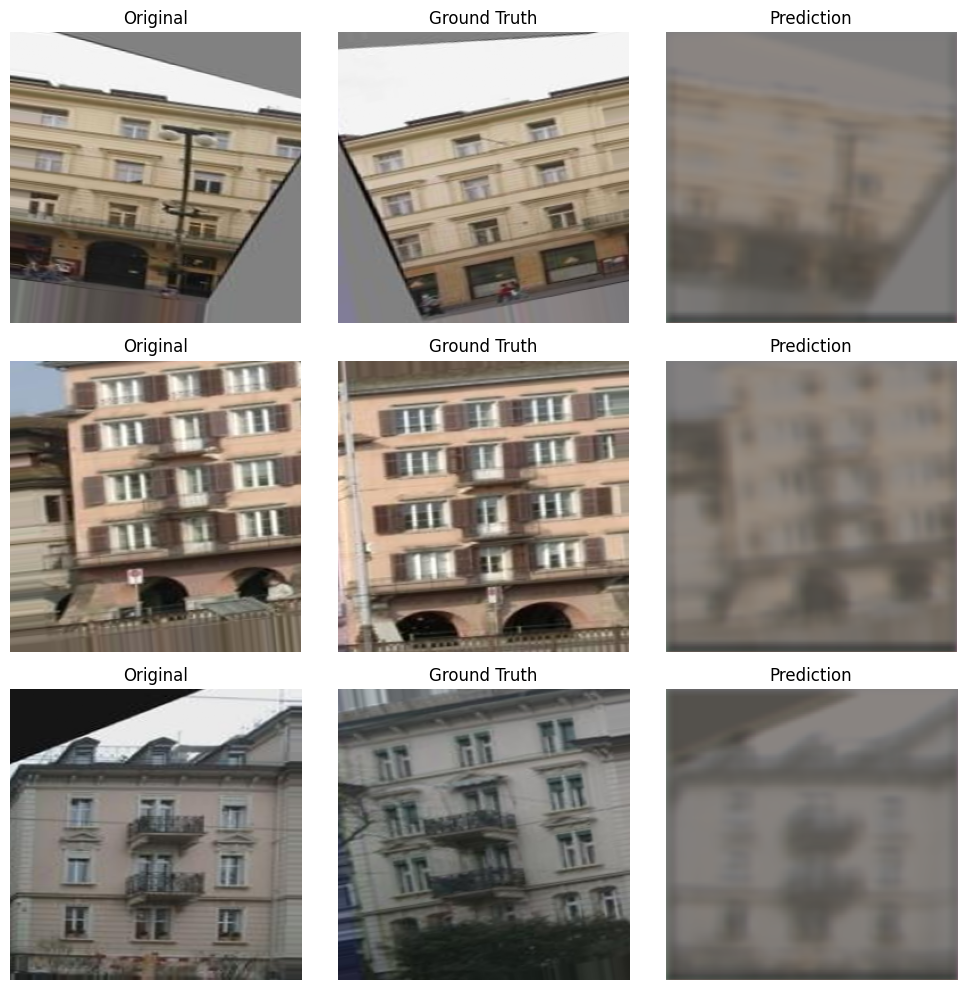

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Load trained model
model = tf.keras.models.load_model("/mnt/data/segmentation_model_v2.keras")

# Get test images
test_folder = os.path.join(dataset_path, "testA")
test_gen = image_generator(test_folder, batch_size=3)
X_test, Y_test = next(test_gen)

# Predict segmentations
predictions = model.predict(X_test)

# Evaluate using PSNR and SSIM
def evaluate_model(predictions, ground_truth):
    psnr_scores = []
    ssim_scores = []

    for i in range(len(predictions)):
        # Compute PSNR
        psnr_value = psnr(ground_truth[i], predictions[i], data_range=1.0)
        psnr_scores.append(psnr_value)

        # Compute SSIM (Fixing win_size issue)
        ssim_value = ssim(ground_truth[i], predictions[i],
                          data_range=1.0, win_size=7, channel_axis=-1)
        ssim_scores.append(ssim_value)

    return np.mean(psnr_scores), np.mean(ssim_scores)

# Evaluate Model
avg_psnr, avg_ssim = evaluate_model(predictions, Y_test)

print(f"📊 Model Evaluation Metrics:")
print(f"✅ Average PSNR: {avg_psnr:.3f}")
print(f"✅ Average SSIM: {avg_ssim:.3f}")

# Display Results
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(Y_test[i])
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(predictions[i])
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


visualizing the model predictoin

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


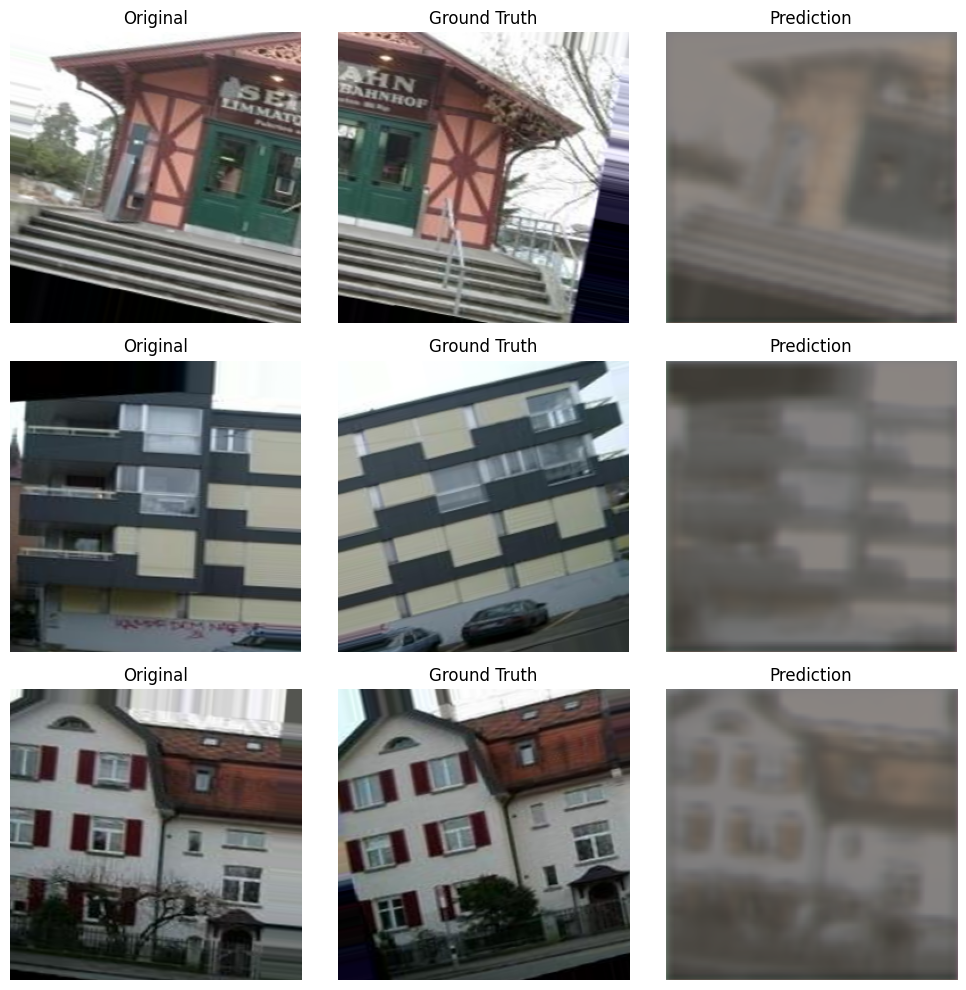

In [ ]:
import matplotlib.pyplot as plt

# Load trained model
model = tf.keras.models.load_model("/mnt/data/segmentation_model_v2.keras")

# Get test images
test_folder = os.path.join(dataset_path, "testA")
test_gen = image_generator(test_folder, batch_size=3)
X_test, Y_test = next(test_gen)

# Predict segmentations
predictions = model.predict(X_test)

# Display results
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(Y_test[i])
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(predictions[i])
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


fine-tune the model using additional data augmentation *italicized text*

In [ ]:
import os
import numpy as np

# Fine-tune data generator (redefine it)
def fine_tune_generator(folder_path, batch_size=16):
    image_files = os.listdir(folder_path)
    np.random.shuffle(image_files)

    while True:  # Ensures generator runs indefinitely
        batch_ground_truth = []
        batch_segmentation_label = []

        for j in range(batch_size):
            idx = np.random.randint(len(image_files))
            image_path = os.path.join(folder_path, image_files[idx])
            ground_truth, segmentation_label = split_image(image_path)

            # Preprocess images
            ground_truth = preprocess_image(ground_truth, TARGET_SIZE)
            segmentation_label = preprocess_image(segmentation_label, TARGET_SIZE)

            batch_ground_truth.append(ground_truth)
            batch_segmentation_label.append(segmentation_label)

        yield np.array(batch_ground_truth), np.array(batch_segmentation_label)


loading model

In [ ]:
import os

# List available files
saved_models = os.listdir("/mnt/data")
print("📂 Available Files:", saved_models)


📂 Available Files: ['facades_dataset', 'segmentation_model_v2.keras', 'segmentation_model.h5']


loading last save again

In [ ]:
import tensorflow as tf
import os

# Load the latest available model
model_path = "/mnt/data/segmentation_model_v2.keras"
model = tf.keras.models.load_model(model_path)

print("✅ Loaded Model Successfully:", model_path)


✅ Loaded Model Successfully: /mnt/data/segmentation_model_v2.keras


In [ ]:
import os

print("📂 Available Files and Folders:", os.listdir("/mnt/data"))


📂 Available Files and Folders: ['facades_dataset', 'segmentation_model_v2.keras', 'segmentation_model.h5']


In [ ]:
import os

dataset_path = "/mnt/data/facades_dataset"
print("📂 Dataset Contents:", os.listdir(dataset_path))


📂 Dataset Contents: ['testA', 'metadata.csv', 'trainA', 'testB', 'trainB']


re-fine tuning :((

In [ ]:
import tensorflow as tf
import os

# ✅ Load the previous trained model
model_path = "/mnt/data/segmentation_model_v2.keras"
model = tf.keras.models.load_model(model_path)

# ✅ Compile before training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy')

# ✅ Define the fine-tune generator (Ensure this function exists)
def fine_tune_generator(folder_path, batch_size=16):
    import numpy as np
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    image_files = os.listdir(folder_path)
    np.random.shuffle(image_files)

    while True:
        batch_ground_truth = []
        batch_segmentation_label = []

        for j in range(batch_size):
            idx = np.random.randint(len(image_files))
            image_path = os.path.join(folder_path, image_files[idx])

            # Load and process images (Ensure these functions exist)
            ground_truth, segmentation_label = split_image(image_path)
            ground_truth = preprocess_image(ground_truth, TARGET_SIZE)
            segmentation_label = preprocess_image(segmentation_label, TARGET_SIZE)

            batch_ground_truth.append(ground_truth)
            batch_segmentation_label.append(segmentation_label)

        yield np.array(batch_ground_truth), np.array(batch_segmentation_label)

# ✅ Ensure correct dataset path
image_folder = "/mnt/data/facades_dataset/trainA"

# ✅ Start fine-tuning
fine_tune_gen = fine_tune_generator(image_folder, batch_size=16)
model.fit(fine_tune_gen, epochs=5, steps_per_epoch=100, verbose=1)

# ✅ Save the fine-tuned model
model.save("/mnt/data/segmentation_model_v4.h5")
print("✅ Fine-Tuned Model Saved Successfully!")


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1144s 11s/step - loss: 0.6701
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1125s 11s/step - loss: 0.6652
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1129s 11s/step - loss: 0.6638
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1139s 11s/step - loss: 0.6617
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1111s 11s/step - loss: 0.6621


✅ Fine-Tuned Model Saved Successfully!


evaluate model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
📊 Model Evaluation Metrics:
✅ Average PSNR: 15.190
✅ Average SSIM: 0.316


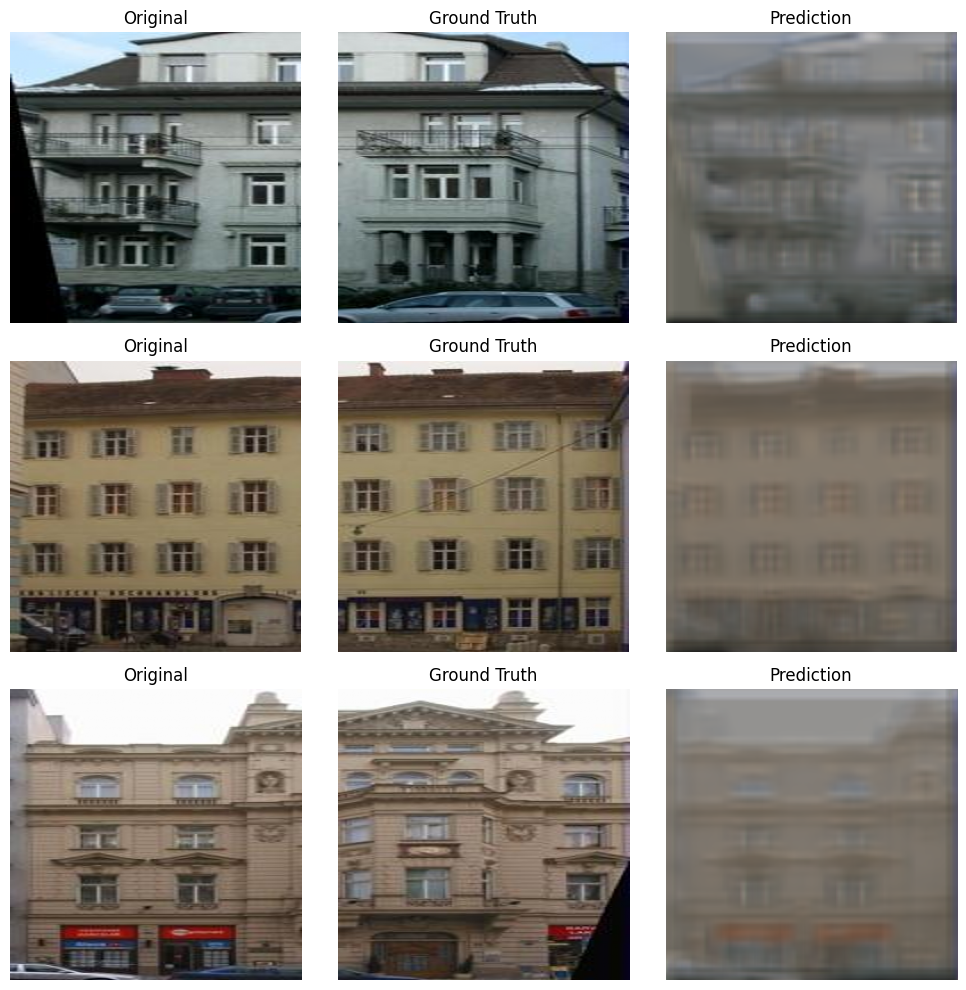

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os

# ✅ Load the fine-tuned model
model_path = "/mnt/data/segmentation_model_v4.h5"
model = tf.keras.models.load_model(model_path)

# ✅ Get test images (Update paths if needed)
test_folder = "/mnt/data/facades_dataset/testA"

def image_generator(folder_path, batch_size=3):
    image_files = os.listdir(folder_path)
    np.random.shuffle(image_files)

    batch_images = []
    batch_labels = []

    for i in range(batch_size):
        idx = np.random.randint(len(image_files))
        image_path = os.path.join(folder_path, image_files[idx])

        # Load image (Ensure split_image function exists)
        ground_truth, segmentation_label = split_image(image_path)
        ground_truth = preprocess_image(ground_truth, TARGET_SIZE)
        segmentation_label = preprocess_image(segmentation_label, TARGET_SIZE)

        batch_images.append(ground_truth)
        batch_labels.append(segmentation_label)

    return np.array(batch_images), np.array(batch_labels)

# ✅ Get test batch
X_test, Y_test = image_generator(test_folder, batch_size=3)

# ✅ Predict segmentations
predictions = model.predict(X_test)

# ✅ Evaluate using PSNR and SSIM
def evaluate_model(predictions, ground_truth):
    psnr_scores = []
    ssim_scores = []

    for i in range(len(predictions)):
        psnr_value = psnr(ground_truth[i], predictions[i], data_range=1.0)
        psnr_scores.append(psnr_value)

        ssim_value = ssim(ground_truth[i], predictions[i], data_range=1.0, win_size=7, channel_axis=-1)
        ssim_scores.append(ssim_value)

    return np.mean(psnr_scores), np.mean(ssim_scores)

# ✅ Compute Evaluation Metrics
avg_psnr, avg_ssim = evaluate_model(predictions, Y_test)

print(f"📊 Model Evaluation Metrics:")
print(f"✅ Average PSNR: {avg_psnr:.3f}")
print(f"✅ Average SSIM: {avg_ssim:.3f}")

# ✅ Visualize Results
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(Y_test[i])
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(predictions[i])
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


model compilation

In [ ]:
import tensorflow as tf

# Compile the model with a loss function and optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("✅ Model Compiled Successfully!")


✅ Model Compiled Successfully!


In [ ]:
print(type(test_gen))  # Check the type of test_gen


<class 'tuple'>


In [ ]:
X_test, Y_test = test_gen  # No need for next()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Load the test dataset
test_folder = "/mnt/data/facades_dataset/testA"  # Adjust the path if needed
test_gen = image_generator(test_folder, batch_size=3)  # Ensure image_generator is defined

# Unpack the tuple directly (since test_gen is a tuple)
X_test, Y_test = test_gen

# Make predictions
predictions = model.predict(X_test)

print("✅ Predictions Done!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Predictions Done!


In [ ]:
X_test = np.array(X_test)  # Ensure it's a NumPy array
import numpy as np

# Ensure X_test has a consistent shape
X_test = np.array(X_test)

# Make predictions
predictions = model.predict(X_test, verbose=0)  # verbose=0 to suppress extra output

print("✅ Predictions Done!")



✅ Predictions Done!


model evaluation

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to evaluate predictions
def evaluate_model(predictions, ground_truth):
    psnr_scores = []
    ssim_scores = []

    for i in range(len(predictions)):
        # Compute PSNR
        psnr_value = psnr(ground_truth[i], predictions[i], data_range=1.0)
        psnr_scores.append(psnr_value)

        # Compute SSIM (Fixing win_size issue)
        ssim_value = ssim(ground_truth[i], predictions[i], data_range=1.0, win_size=7, channel_axis=-1)
        ssim_scores.append(ssim_value)

    return np.mean(psnr_scores), np.mean(ssim_scores)

# Evaluate model
avg_psnr, avg_ssim = evaluate_model(predictions, Y_test)

print(f"📊 Model Evaluation Metrics:")
print(f"✅ Average PSNR: {avg_psnr:.3f}")
print(f"✅ Average SSIM: {avg_ssim:.3f}")


📊 Model Evaluation Metrics:
✅ Average PSNR: 12.945
✅ Average SSIM: 0.241


visualization

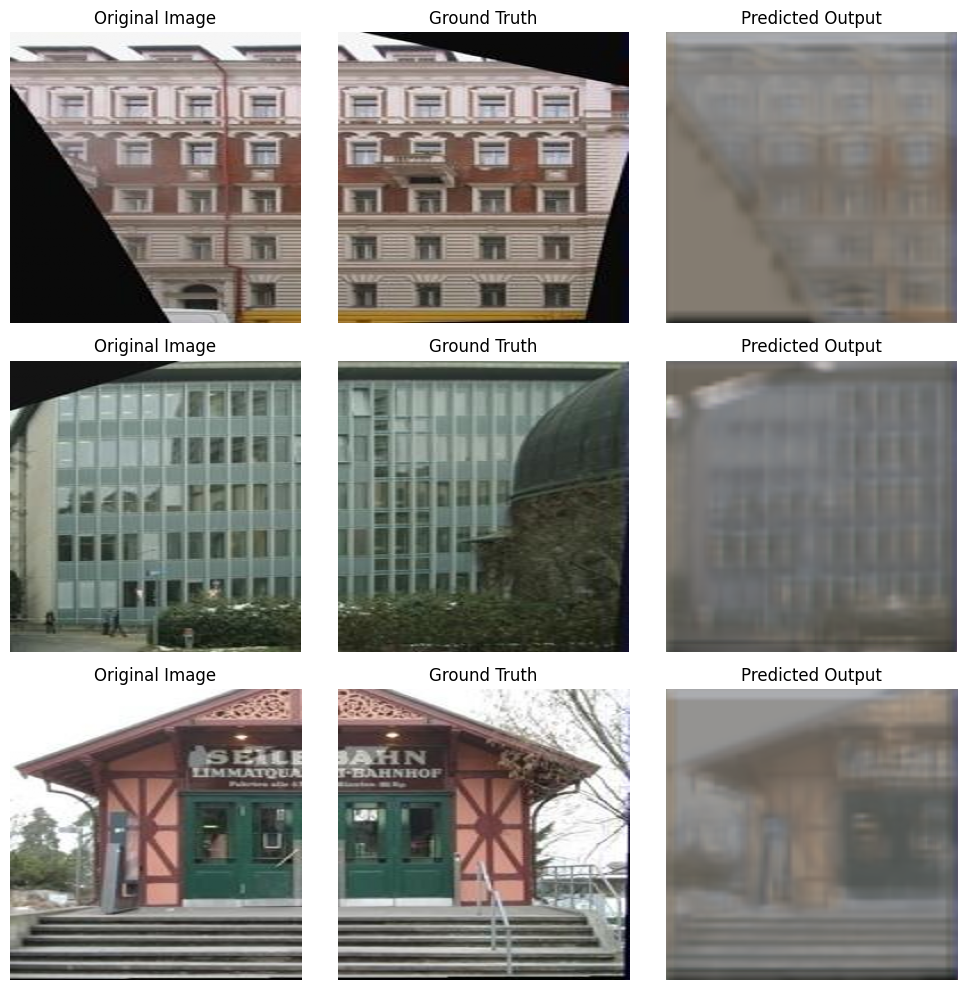

In [ ]:
import matplotlib.pyplot as plt

# Display results
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):  # Display 3 samples
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(Y_test[i])
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(predictions[i])
    axes[i, 2].set_title("Predicted Output")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1117s 11s/step - accuracy: 0.7047 - loss: 0.6612
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1109s 11s/step - accuracy: 0.6914 - loss: 0.6591
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1109s 11s/step - accuracy: 0.6878 - loss: 0.6576
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1111s 11s/step - accuracy: 0.7146 - loss: 0.6598
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1108s 11s/step - accuracy: 0.7156 - loss: 0.6593


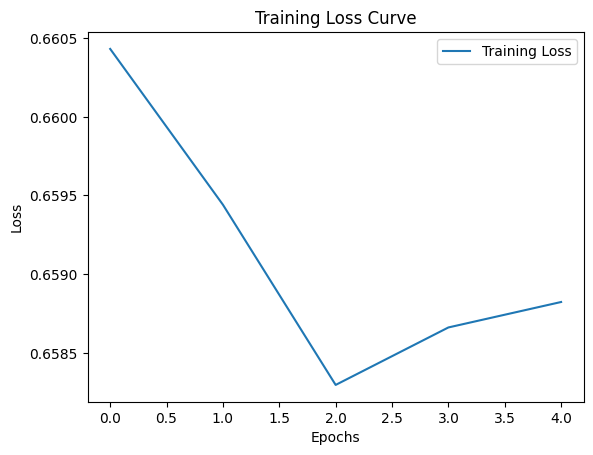

In [ ]:
# Train the model and save history
history = model.fit(fine_tune_gen, epochs=5, steps_per_epoch=100, verbose=1)

# Now plot the loss curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


 Observations:
The loss decreases initially (which is good ✅).
However, after reaching a minimum, the loss starts increasing again (potential overfitting ❌).
Accuracy is fluctuating, which means the model might not be learning consistently.


evaluatiing on test set


In [ ]:
test_gen = image_generator(test_folder, batch_size=3)  # Ensure image_generator is defined
sample_output = next(iter(test_gen))

print("Type of output:", type(sample_output))  # Check the type
print("Length of output:", len(sample_output))  # Check the number of items


Type of output: <class 'numpy.ndarray'>
Length of output: 3


In [ ]:
X_test = sample_output  # Only inputs are returned, no ground truth


In [ ]:
print("Sample batch shape:", X_test.shape)  # Check the shape


Sample batch shape: (3, 256, 256, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Load the test dataset
test_folder = "/mnt/data/facades_dataset/testA"  # Adjust the path if needed
test_gen = image_generator(test_folder, batch_size=10)  # Ensure image_generator is defined
X_test = next(iter(test_gen))  # Extract images from generator

# Make predictions
predictions = model.predict(X_test)
print("✅ Predictions Done!")

# Ensure predictions are scaled properly (if needed)
if predictions.max() <= 1.0:
    predictions *= 255.0  # Rescale to match image range

# Function to calculate PSNR and SSIM
def evaluate_predictions(X_test, predictions):
    psnr_values = []
    ssim_values = []

    for i in range(len(X_test)):
        original = X_test[i]  # Input image
        predicted = predictions[i]  # Model output

        # Convert images to grayscale for SSIM calculation
        original_gray = np.mean(original, axis=-1)
        predicted_gray = np.mean(predicted, axis=-1)

        # Normalize grayscale images to [0, 255] range for fair comparison
        original_gray = (original_gray - original_gray.min()) / (original_gray.max() - original_gray.min()) * 255.0
        predicted_gray = (predicted_gray - predicted_gray.min()) / (predicted_gray.max() - predicted_gray.min()) * 255.0

        # Compute PSNR & SSIM
        psnr_value = psnr(original_gray, predicted_gray, data_range=255)
        ssim_value = ssim(original_gray, predicted_gray, data_range=255)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"\n📊 **Model Evaluation Metrics:**")
    print(f"✅ **Average PSNR:** {avg_psnr:.3f}")
    print(f"✅ **Average SSIM:** {avg_ssim:.3f}")

# Run Evaluation
evaluate_predictions(X_test, predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Predictions Done!

📊 **Model Evaluation Metrics:**
✅ **Average PSNR:** 14.730
✅ **Average SSIM:** 0.377


 PSNR (14.73) and SSIM (0.377)